In [57]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools import eval_measures
import statsmodels.regression
import statsmodels.tools
import warnings
#from fbprophet import Prophet
warnings.filterwarnings('ignore')
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## some datetime conversion warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Always make it pretty.
plt.style.use('ggplot')


In [63]:
#Some borrowed functions Galvanize time series lecture 2020
def plot_trend_data(ax, name, series):
    ax.plot(series.index.date, series)
    ax.set_title("Seasonal Trend {}".format(name))

def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).iloc[:, :11]



def create_weekly_dummies(series):
    week = series.index.week
    # Only take 51 of the 52 dummies to avoid strict colinearity.
    return pd.get_dummies(week).iloc[:, :51]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def fit_weekly_seasonal_trend(series):
    dummies = create_weekly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')

def plot_weekly_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_weekly_seasonal_trend(series)
    plot_trend_data(ax, name, series, )
    ax.plot(series.index.date, seasons_average_trend, '-')



def plot_seasonal_decomposition(axs, series, sd):
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", 
                         "Trend Component $T_t$", 
                         "Seasonal Component $S_t$",
                         "Residual Component $R_t$"])
    
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))

def plot_series_and_difference(axs, series, title):
    diff = series.diff(periods =52)
    axs[0].plot(series.index.date, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index.date, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

def plot_acf_pacf(your_data, lags):
    fig = plt.figure(figsize=(14,10))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(your_data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(your_data, lags=lags, ax=ax2, method='ywm')
    plt.show()
    
    



In [74]:
# Borrowd functions from 
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


#stack overflow
def rms(y_test, y_predict):
    return (sqrt(mean_squared_error(y_test, y_predict[0:68])))

In [64]:
ten_year_influenza_confirmed = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/ten_year_influenza_confirmed.csv")

In [170]:
ten_year_influenza_confirmed['date'] = pd.to_datetime(ten_year_influenza_confirmed['date']).dt.date

In [171]:
total_infections =ten_year_influenza_confirmed.groupby(["date"]).sum()
mean_total_infections = ten_year_influenza_confirmed.groupby(["date"]).mean()

total_infections.reset_index(inplace=True)
mean_total_infections.reset_index(inplace = True)


#what is the mean number of confirmed infections for each state
state_mean_total_infections = ten_year_influenza_confirmed.groupby(["REGION"]).mean()
state_mean_total_infections.head()
total_infections = total_infections.set_index(pd.DatetimeIndex(total_infections.date))

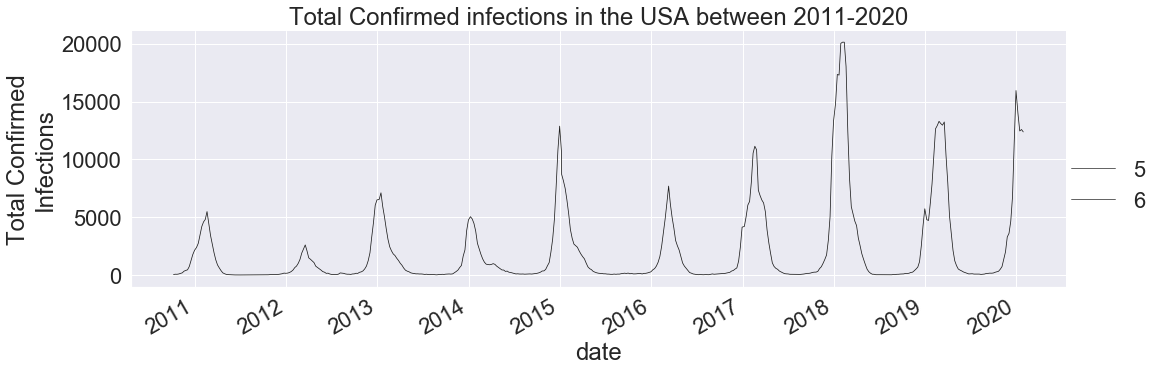

In [172]:
sns.set(font_scale=2)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=total_infections , size=6, aspect=3,
                color ="k") 
g.set_ylabels("Total Confirmed\nInfections") 
#plt.ylabel("Confirmed\nInfections")              
g.fig.autofmt_xdate()
plt.title("Total Confirmed infections in the USA between 2011-2020") 
plt.plot()
plt.savefig("total US infections", bbox_inches = "tight") 

In [33]:
split_point = len(total_infections['Confirmed_Infections']) - 68
train_dataset, test_dataset = total_infections['Confirmed_Infections'][0:split_point], total_infections['Confirmed_Infections'][split_point:]


In [32]:
#test_dataset = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/data/test_CDC_data.csv")

# Examine the data for seasonality and stationarity

start first by decomposing the data

In [34]:
influenza_decomposition = sm.tsa.seasonal_decompose(train_dataset, period =52)

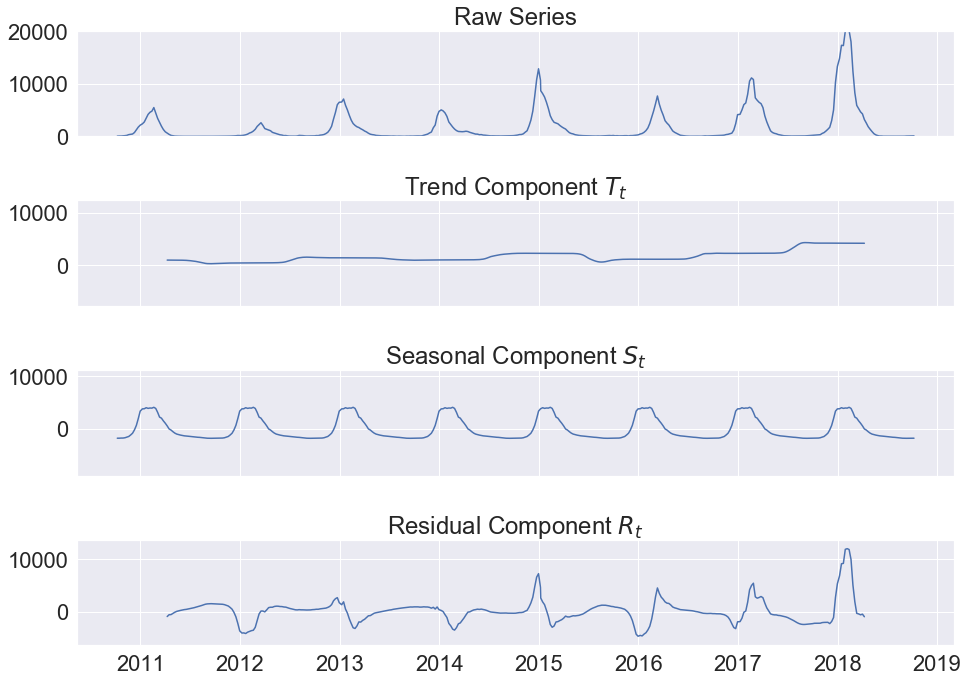

In [35]:
fig, axs = plt.subplots(4, figsize=(14, 10), sharex=True)
plot_seasonal_decomposition(axs, 
                            train_dataset, 
                            influenza_decomposition)
plt.tight_layout()

Augmented Dickey-Fuller test for stationarity with:

  * 𝐻0 : The series is not-stationary (specifically, has a unit root).
  * 𝐻a : The series is stationary

In [44]:
test = sm.tsa.stattools.adfuller(train_dataset)
print("ADF p-value for python series: {0:2.6f}".format(test[1]))

test = sm.tsa.stattools.adfuller(train_dataset.diff()[52:])
print("ADF p-value for differenced python series: {0:2.12f}".format(test[1]))

ADF p-value for python series: 0.000014
ADF p-value for differenced python series: 0.000000000009


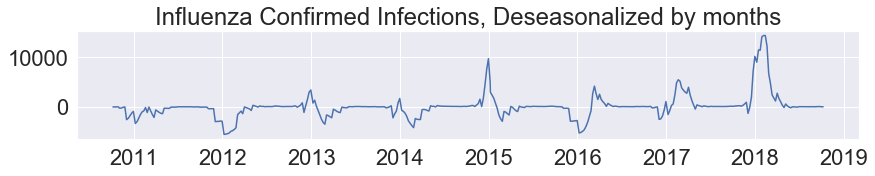

In [49]:
influenza_seasonal_trend = fit_seasonal_trend(train_dataset)
influenza_seasonal_detrended = train_dataset - influenza_seasonal_trend

fig, ax = plt.subplots(figsize=(14, 2))
ax.plot(train_dataset.index, influenza_seasonal_detrended)
ax.set_title("Influenza Confirmed Infections, Deseasonalized by months");

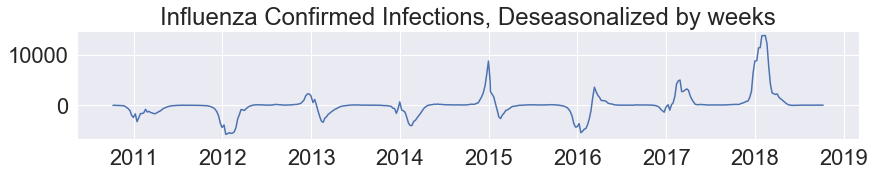

In [45]:
influenza_seasonal_trend = fit_weekly_seasonal_trend(train_dataset)
influenza_seasonal_detrended = train_dataset - influenza_seasonal_trend

fig, ax = plt.subplots(figsize=(14, 2))
ax.plot(train_dataset.index, influenza_seasonal_detrended)
ax.set_title("Influenza Confirmed Infections, Deseasonalized by weeks");

ADF p-value for python series: 0.000014


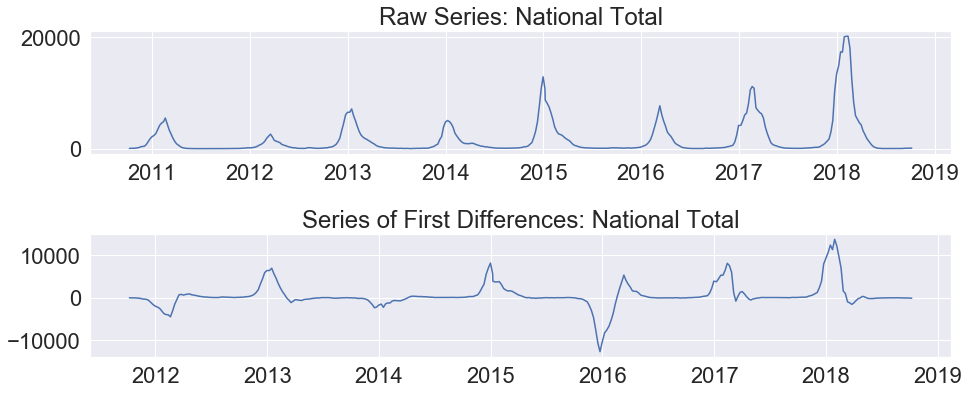

In [51]:
fig, axs = plt.subplots(2, figsize=(14, 6))
plot_series_and_difference(axs, train_dataset, 'National Total')
fig.tight_layout()

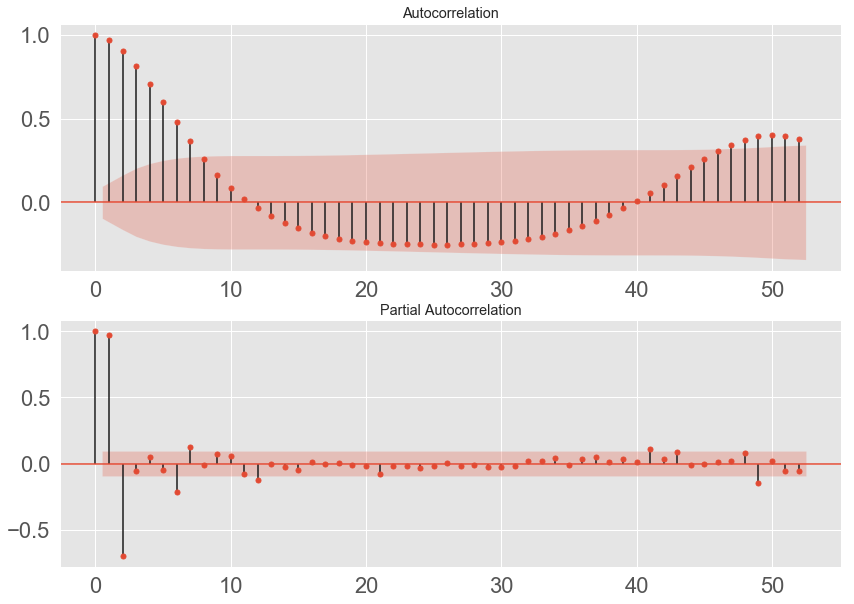

In [66]:
plot_acf_pacf(train_dataset,52)

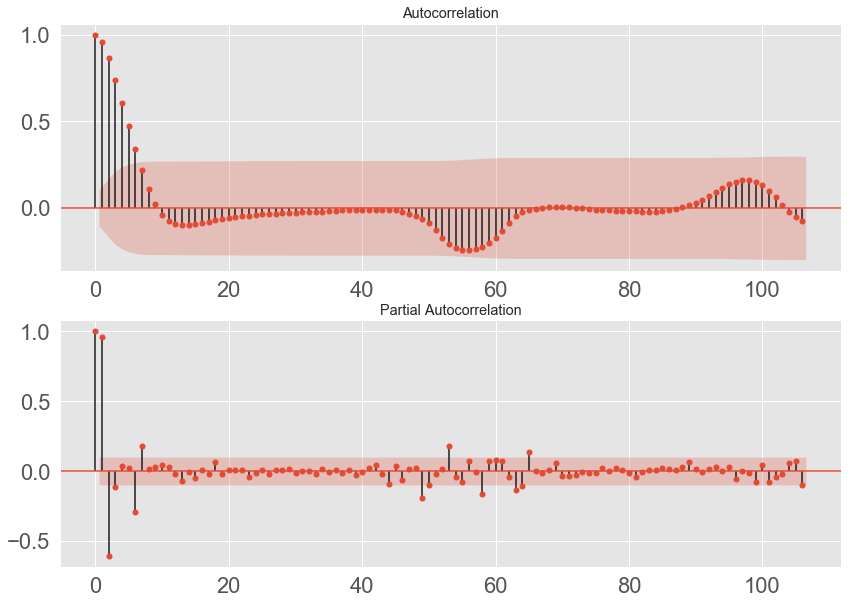

In [65]:
train_differenced_dataset = train_dataset.diff(periods =52).dropna()

plot_acf_pacf(train_differenced_dataset,53*2)

### p,d,q for the differenced data 4,0,7 or 3,0,7.. try both and compare AIC

In [67]:
#Which model has a lower AIC
national_ARIMA_model_407 = ARIMA(train_differenced_dataset,order=(4,0,6)).fit()
national_ARIMA_model_307 = ARIMA(train_differenced_dataset,order=(3,0,6)).fit()



print("national_ARIMA_model_407 - national_ARIMA_model_307 = ",national_ARIMA_model_407.aic - national_ARIMA_model_307.aic)


national_ARIMA_model_407 - national_ARIMA_model_307 =  -0.26033575606925297


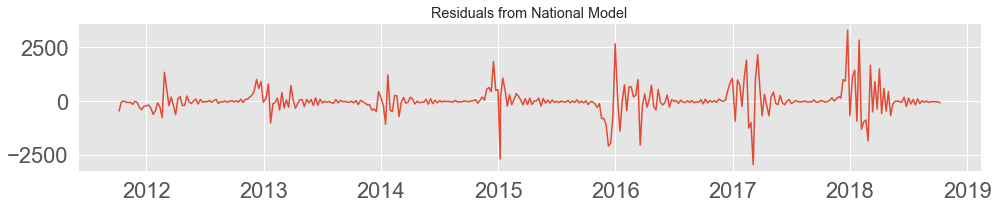

In [68]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(national_ARIMA_model_407.resid.index, national_ARIMA_model_407.resid)
ax.set_title("Residuals from National Model (4,0,7)")
plt.tight_layout()

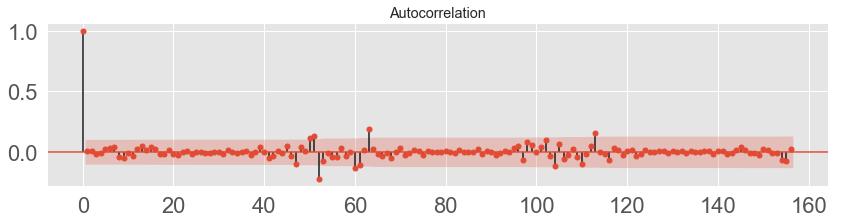

In [69]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(national_ARIMA_model_407.resid, lags=3*52, ax=ax)

In [70]:
print(national_ARIMA_model_407.summary())

                               ARMA Model Results                               
Dep. Variable:     Confirmed_Infections   No. Observations:                  366
Model:                       ARMA(4, 6)   Log Likelihood               -2857.053
Method:                         css-mle   S.D. of innovations            590.778
Date:                  Thu, 06 Feb 2020   AIC                           5738.107
Time:                          17:42:00   BIC                           5784.938
Sample:                               0   HQIC                          5756.716
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        455.3055    388.400      1.172      0.241    -305.945    1216.556
ar.L1.Confirmed_Infections     0.3797      0.201      1.894      0.

In [71]:
predict = national_ARIMA_model_407.predict(start = 470-104, end=486-52)

In [72]:
predict.index = pd.date_range(start='2018-10-01', end='2020-01-29', freq='W')


In [75]:

predicted_inverse_difference = inverse_difference(train_dataset, predict,52)

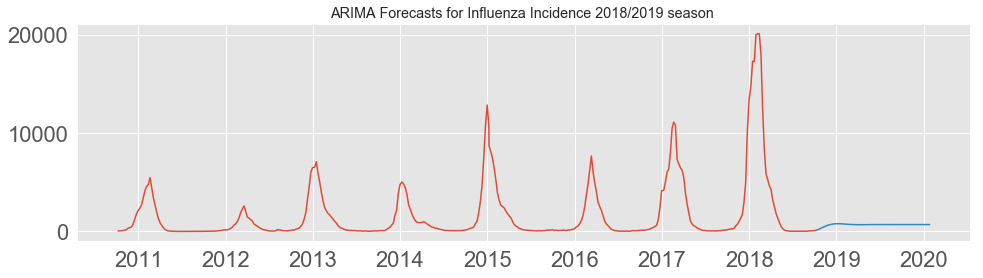

In [78]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(predict.index, predicted_inverse_difference)
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("ARIMA Forecasts for Influenza Incidence 2018/2019 season ");

In [79]:
parameters = [
    {'AR': 4, 'MA': 6},
    {'AR': 3, 'MA': 6},
    {'AR': 4, 'MA': 7},
    {'AR': 3, 'MA': 7},
    {'AR': 2, 'MA': 6},
    {'AR': 2, 'MA': 7},
    {'AR': 5, 'MA': 6},
    {'AR': 5, 'MA': 7}
    
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(train_differenced_dataset , 
                                                 order=(params['AR'],
                                                        0, 
                                                        params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 0, {}) AIC: {}".format(model_params[0], 
                                            model_params[1], 
                                            models[model_params].aic))

ARIMA(4, 0, 6) AIC: 5738.106514196748
ARIMA(3, 0, 6) AIC: 5738.366849952818
ARIMA(4, 0, 7) AIC: 5738.293544551055
ARIMA(3, 0, 7) AIC: 5739.867957218779
ARIMA(2, 0, 6) AIC: 5738.330692965253
ARIMA(2, 0, 7) AIC: 5738.934888690035
ARIMA(5, 0, 6) AIC: 5736.309719903267
ARIMA(5, 0, 7) AIC: 5737.910131432403


In [80]:
print (" The root means square error is :",rms(test_dataset, predicted_inverse_difference[0:68]))

 The root means square error is : 5871.982131170511


In [81]:
national_ARIMA_506= ARIMA(train_differenced_dataset,order=(5,0,6)).fit()

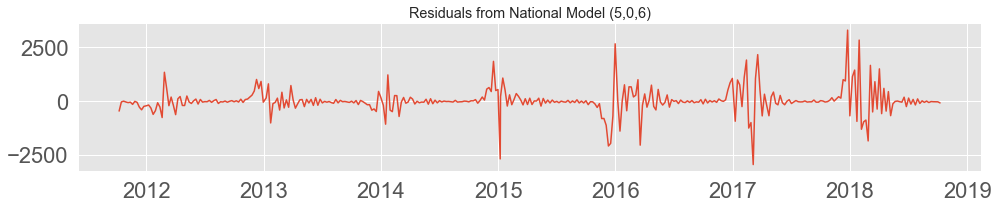

In [82]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(national_ARIMA_506.resid.index, national_ARIMA_model_407.resid)
ax.set_title("Residuals from National Model (5,0,6)")
plt.tight_layout()

In [83]:
predict = national_ARIMA_506.predict(start = 470-104, end=486-52)

In [84]:
predict.index = pd.date_range(start='2018-10-01', end='2020-01-29', freq='W')
predicted_inverse_difference = inverse_difference(train_dataset, predict,52)

In [85]:
print (" The root means square error is :",rms(test_dataset, predicted_inverse_difference[0:68]))

 The root means square error is : 5885.898874012742


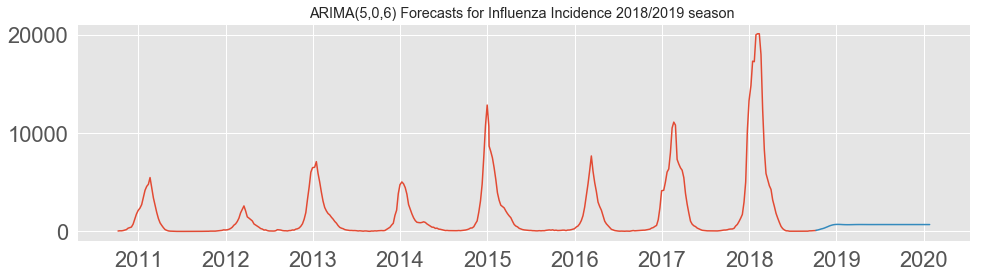

In [86]:
fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(train_dataset.index, train_dataset)
ax.plot(predict.index, predicted_inverse_difference)
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.set_title("ARIMA(5,0,6) Forecasts for Influenza Incidence 2018/2019 season ");

In [143]:
predicted_inverse_difference = inverse_difference(train_dataset, predict,52)


train_dataset.index[-1]

Timestamp('2018-10-08 00:00:00')

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(train_dataset.index, train_dataset)
fig = national_ARIMA_506.plot_predict('2011-11-30', '2013', 
                                  dynamic=True, ax=ax, plot_insample=False)

ax.legend().get_texts()[1].set_text("95% Prediction Interval")
ax.legend(loc="lower left")

ax.set_title("Electric Series Forcasts from ARIMA Model");

In [139]:
national_model = SARIMAX(train_dataset,
                         order=(4,1,7)
                         ,seasonal_order=(4,1,7,10)).fit()


os.system('afplay /System/Library/Sounds/Blow.aiff')


0

In [140]:
print(national_model.summary())
    

                                     SARIMAX Results                                      
Dep. Variable:               Confirmed_Infections   No. Observations:                  418
Model:             SARIMAX(4, 1, 7)x(4, 1, 7, 10)   Log Likelihood               -3195.406
Date:                            Thu, 06 Feb 2020   AIC                           6436.812
Time:                                    19:14:16   BIC                           6529.015
Sample:                                         0   HQIC                          6473.301
                                            - 418                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5141      0.547      0.940      0.347      -0.557       1.586
ar.L2          0.3365      0.615   

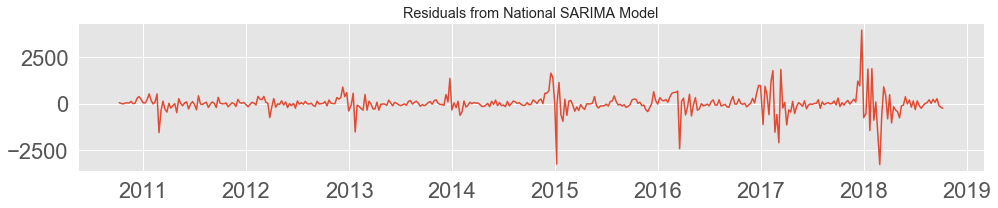

In [141]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(national_model.resid.index, national_model.resid)
ax.set_title("Residuals from National SARIMA Model")
plt.tight_layout()

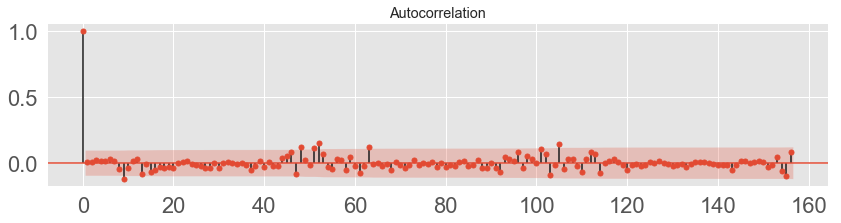

In [142]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(national_model.resid, lags=3*52, ax=ax)

Timestamp('2020-01-29 00:00:00')

In [181]:
# train_dataset = train_dataset.reindex(pd.date_range(
#         start='2010-10-08', end='2020-01-29', freq='W'))

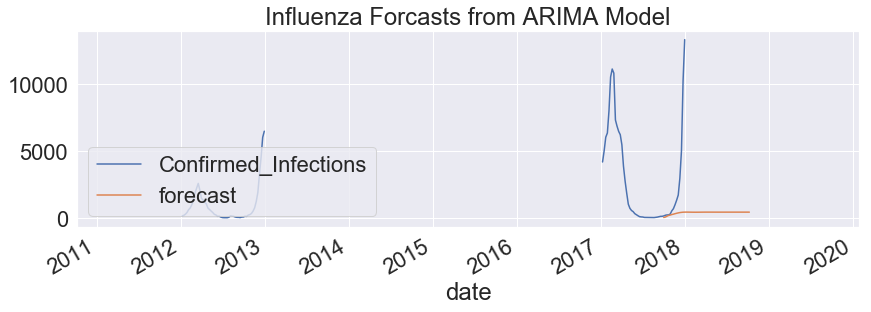

In [186]:
# fig, ax = plt.subplots(1, figsize=(14, 4))
# ax.plot(train_dataset.index, train_dataset)
# fig = national_ARIMA_506.plot_predict(str('2017-10-01'), str('2018-10-08'), 
#                                   dynamic=True, ax=ax, plot_insample=False)

# ax.legend().get_texts()[1].set_text("95% Prediction Interval")
# ax.legend(loc="lower left")

# ax.set_title("Influenza Forcasts from ARIMA Model")
# plt.savefig("images/what");

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [160]:
len(predict)

69

In [161]:
len(test_dataset)

68

In [165]:
test_dataset.index[0]

Timestamp('2018-10-15 00:00:00')